### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import neighbors, model_selection, metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression
import statistics
import graphviz
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from subprocess import check_call
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
import matplotlib.patches as mpatches
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

### Aux. functions

In [3]:
def compute_metrics(confusion_matrix):
    #https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)

    # Specificity or true negative rate
    TNR = TN / (TN + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    
    cost = FP * 10 + FN * 500
    #Specific to this example
    return TPR,TNR, cost

def preprocessData(df):
    label_encoder = preprocessing.LabelEncoder()
    dummy_encoder = preprocessing.OneHotEncoder()
    pdf = pd.DataFrame()
    for att in df.columns:
        if df[att].dtype == np.float64 or df[att].dtype == np.int64:
            pdf = pd.concat([pdf, df[att]], axis=1)
        else:
            df[att] = label_encoder.fit_transform(df[att])
            # Fitting One Hot Encoding on train data
            temp = dummy_encoder.fit_transform(df[att].values.reshape(-1,1)).toarray()
            # Changing encoded features into a dataframe with new column names
            temp = pd.DataFrame(temp,
                                columns=[(att + "_" + str(i)) for i in df[att].value_counts().index])
            # In side by side concatenation index values should be same
            # Setting the index values similar to the data frame
            temp = temp.set_index(df.index.values)
            # adding the new One Hot Encoded varibales to the dataframe
            pdf = pd.concat([pdf, temp], axis=1)
    return pdf

def fill_missing_values(dataset, feature_names, class_name = None):
    dataset_preprocessed = dataset.copy()
    
    if class_name == None:
        for feature in feature_names:
            dataset_preprocessed[feature] = dataset_preprocessed.transform(lambda x: x.fillna(x.mean()))[feature]
    else:
        for feature in feature_names:
            dataset_preprocessed[feature] = dataset_preprocessed.groupby(class_name).transform(lambda x: x.fillna(x.mean()))[feature]

    return dataset_preprocessed

# First dataset

## Load data

In [4]:
green_ds = pd.read_csv("datasets/second/green.csv")
hinselmann_ds = pd.read_csv("datasets/second/hinselmann.csv")
schiller_ds = pd.read_csv("datasets/second/schiller.csv")

cols = green_ds.columns[:-7]
'''
green_ds["green_ds"] = 1
green_ds["hinselmann_ds"] = 0
green_ds["schiller_ds"] = 0

hinselmann_ds["green_ds"] = 0
hinselmann_ds["hinselmann_ds"] = 1
hinselmann_ds["schiller_ds"] = 0

schiller_ds["green_ds"] = 0
schiller_ds["hinselmann_ds"] = 0
schiller_ds["schiller_ds"] = 1
'''

ds = pd.concat([green_ds,hinselmann_ds,schiller_ds])

print(cols.shape)

ds.info()
ds.describe()
ds.corr()

(62,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 0 to 91
Data columns (total 69 columns):
cervix_area                    287 non-null float64
os_area                        287 non-null float64
walls_area                     287 non-null float64
speculum_area                  287 non-null float64
artifacts_area                 287 non-null float64
cervix_artifacts_area          287 non-null float64
os_artifacts_area              287 non-null float64
walls_artifacts_area           287 non-null float64
speculum_artifacts_area        287 non-null float64
cervix_specularities_area      287 non-null float64
os_specularities_area          287 non-null float64
walls_specularities_area       287 non-null float64
speculum_specularities_area    287 non-null float64
specularities_area             287 non-null float64
area_h_max_diff                287 non-null float64
rgb_cervix_r_mean              287 non-null float64
rgb_cervix_r_std               287 non-null float64
rgb_ce

,cervix_area,os_area,walls_area,speculum_area,artifacts_area,cervix_artifacts_area,os_artifacts_area,walls_artifacts_area,speculum_artifacts_area,cervix_specularities_area,...,fit_ellipse_goodness,dist_to_center_cervix,dist_to_center_os,experts::0,experts::1,experts::2,experts::3,experts::4,experts::5,consensus
cervix_area,1.000000,0.279679,-0.343735,-0.560051,-0.211677,-0.155234,-0.099239,-0.172976,-0.087426,-0.229973,...,0.511095,-0.334462,-0.360214,0.138724,0.130433,0.015102,0.048871,-0.097192,0.058027,0.078524
os_area,0.279679,1.000000,-0.133563,-0.103413,0.036662,0.093395,0.290848,0.003263,0.044402,-0.035988,...,0.032053,-0.347099,-0.191693,0.081538,0.086173,0.023047,0.053312,0.071087,0.130113,0.088354
walls_area,-0.343735,-0.133563,1.000000,-0.291616,-0.052084,-0.092824,-0.069373,-0.052929,0.013883,-0.099545,...,-0.240488,0.275467,0.287357,-0.164081,-0.108746,-0.055384,-0.025838,-0.006224,-0.071695,-0.190045
speculum_area,-0.560051,-0.103413,-0.291616,1.000000,0.185359,0.254356,0.113007,0.158240,0.113079,0.381105,...,-0.264662,0.138086,0.071775,-0.065599,-0.047472,-0.010365,0.003900,0.096166,-0.063217,0.054867
artifacts_area,-0.211677,0.036662,-0.052084,0.185359,1.000000,0.429364,0.322340,0.358640,0.579612,0.107493,...,-0.014720,0.126496,-0.052487,0.028270,-0.139680,-0.026690,-0.059695,0.008945,0.007533,-0.040410
cervix_artifacts_area,-0.155234,0.093395,-0.092824,0.254356,0.429364,1.000000,0.566487,0.107517,0.057844,0.288241,...,-0.060842,0.124848,-0.035116,-0.000337,-0.104432,-0.016683,-0.046730,0.125899,-0.023715,0.000799
os_artifacts_area,-0.099239,0.290848,-0.069373,0.113007,0.322340,0.566487,1.000000,0.124076,0.097782,0.157627,...,-0.034478,-0.058158,-0.056660,0.014068,-0.024038,0.092949,0.062289,0.047679,0.110058,0.062817
walls_artifacts_area,-0.172976,0.003263,-0.052929,0.158240,0.358640,0.107517,0.124076,1.000000,0.086013,0.199253,...,0.020612,0.038670,0.033643,-0.063381,-0.069658,0.035726,-0.020464,0.050006,-0.089334,-0.022750
speculum_artifacts_area,-0.087426,0.044402,0.013883,0.113079,0.579612,0.057844,0.097782,0.086013,1.000000,-0.012307,...,-0.039770,0.164847,0.009589,-0.108709,-0.147872,-0.050835,-0.052116,-0.102084,-0.068372,-0.094307
cervix_specularities_area,-0.229973,-0.035988,-0.099545,0.381105,0.107493,0.288241,0.157627,0.199253,-0.012307,1.000000,...,-0.040006,0.096213,-0.075830,-0.013103,-0.149375,-0.071001,-0.043209,0.101796,-0.021433,0.021551


In [5]:
class_attributes = [
    "consensus",
    "experts::0",
    "experts::1",
    "experts::2",
    "experts::3",
    "experts::4",
    "experts::5",
    ]

X = ds.drop(labels = class_attributes, axis = "columns")
feature_names = X.columns.tolist()

Y = ds[class_attributes[0]]
unique, counts = np.unique(Y, return_counts=True)
ocorrences = dict(zip(unique, counts))
labels = pd.unique(Y)
Y = label_binarize(Y, classes=labels).reshape(-1)
positives = ds.loc[ds[class_attributes[0]] == 1.0]

X.shape

(287, 62)

# Pre-processing 1

In [6]:
def normalize (dataset, feature_names, class_attributes):
    dataset_x = dataset.drop(labels = class_attributes, axis = "columns")
    dataset_y = dataset[class_attributes[0]]
    X_norm = preprocessing.normalize(dataset_x)
    preproc_1 = pd.DataFrame(data=X_norm, columns = feature_names)
    #preproc_1.insert(len(feature_names), class_attributes[0], dataset_y)
    return preproc_1

In [7]:
result_pre1 = normalize(ds, feature_names, class_attributes)

X_preproc_1 = result_pre1
X_preproc_1.shape

(287, 62)

# Pre-processing 3

In [8]:
def preproc_3(X, y):
    sm = SMOTE(random_state=2)
    X_sm, y_sm = sm.fit_sample(X, y.ravel())

    preproc_3 = pd.DataFrame(data=X_sm, columns = feature_names)
    
    return preproc_3, y_sm

In [9]:
X_preproc_3, Y_preproc_3 = preproc_3(X, Y)

Y_preproc_3.shape
#Y_preproc_3.tolist()

(432,)

# Pre-processing 4

In [10]:
def preproc_4 (dataset_filled_mv,y_train_filled_mv, num_cols, cols):
    
    X_train_filled_mv = dataset_filled_mv
    X_train_mv_norm = preprocessing.normalize(X_train_filled_mv)
    
    k = len(X_train_filled_mv.columns)
    selector = SelectKBest(score_func=chi2, k=k - num_cols)
    selector.fit(X_train_mv_norm, y_train_filled_mv)
    idxs_selected = selector.get_support(indices=True)
    
    columns = X_train_mv_norm[0][idxs_selected]
    features_dataframe_new = X_train_mv_norm[:,idxs_selected]
    
    #cols = dataset_filled_mv.iloc[:,1:].columns[idxs_selected]
    preproc_4 = pd.DataFrame(data = features_dataframe_new, columns=cols[idxs_selected])

    return preproc_4

In [11]:
X_no_negatives = X
for attr in X:
    X_no_negatives[attr] = ds.transform(lambda x: x + abs(x.min()))[attr]
X_no_negatives.shape

(287, 62)

In [12]:
result_pre4 = preproc_4(X_no_negatives,Y, 10, cols)
X_preproc_4 = result_pre4
#Y_preproc_4 = label_binarize(Y_preproc_4, classes=Y_preproc_4.unique())
X_preproc_4.shape

(287, 52)

# ------------------------------------------------- KNN ---------------------------------------------------

In [13]:
n_splits = 5
kf = model_selection.KFold(n_splits = n_splits)
Ks = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,30]

accurracies_knn, accurracies_knn_pre1, accurracies_knn_pre3, accurracies_knn_pre4 = [], [], [], []
costs_knn, costs_knn_pre1, costs_knn_pre3, costs_knn_pre4 = [], [], [], []
tpr_knn, tpr_knn_pre1, tpr_knn_pre3, tpr_knn_pre4 = [], [], [], []
fpr_knn, fpr_knn_pre1, fpr_knn_pre3, fpr_knn_pre4 = [], [], [], []

X_train0, X_test0, Y_train0, Y_test0 = model_selection.train_test_split(X,Y, train_size = 0.7, test_size = 0.3, stratify = Y)
X_train1, X_test1, Y_train1, Y_test1 = model_selection.train_test_split(X_preproc_1,Y, train_size = 0.7, test_size = 0.3, stratify = Y)
X_train3, X_test3, Y_train3, Y_test3 = model_selection.train_test_split(X_preproc_3,Y_preproc_3, train_size = 0.7, test_size = 0.3, stratify = Y_preproc_3)
X_train4, X_test4, Y_train4, Y_test4 = model_selection.train_test_split(X_preproc_4,Y, train_size = 0.7, test_size = 0.3, stratify = Y)

for k in Ks:
    print("K =",k)
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    
    print("___1___")
    model = knn.fit(X_train0,Y_train0)
    predY = model.predict(X_test0)

    cm = metrics.confusion_matrix(Y_test0, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test0, Y_test0)
    fpr, tpr, thresholds = roc_curve(Y_test0, predY)
    accurracies_knn.append(accurracy)
    costs_knn.append(cost[0])
    tpr_knn.append(tpr)
    fpr_knn.append(fpr)
    print(cm)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("Acurracy: ", accurracy)
    
    print("___1___")
    
    model = knn.fit(X_train1,Y_train1)
    predY = model.predict(X_test1)

    cm = metrics.confusion_matrix(Y_test1, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test1, Y_test1)
    fpr, tpr, thresholds = roc_curve(Y_test1, predY)
    accurracies_knn_pre1.append(accurracy)
    costs_knn_pre1.append(cost[0])
    tpr_knn_pre1.append(tpr)
    fpr_knn_pre1.append(fpr)
    print(cm)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("Acurracy: ", accurracy)
    
    print("___3___") 
    
    model = knn.fit(X_train3,Y_train3)
    predY = model.predict(X_test3)

    cm = metrics.confusion_matrix(Y_test3, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test3, Y_test3)
    fpr, tpr, thresholds = roc_curve(Y_test3, predY)
    accurracies_knn_pre3.append(accurracy)
    costs_knn_pre3.append(cost[0])
    tpr_knn_pre3.append(tpr)
    fpr_knn_pre3.append(fpr)
    print(cm)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("Acurracy: ", accurracy)
    
    print("___4___") 
    
    model = knn.fit(X_train4,Y_train4)
    predY = model.predict(X_test4)

    cm = metrics.confusion_matrix(Y_test4, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test4, Y_test4)
    fpr, tpr, thresholds = roc_curve(Y_test4, predY)
    accurracies_knn_pre4.append(accurracy)
    costs_knn_pre4.append(cost[0])
    tpr_knn_pre4.append(tpr)
    fpr_knn_pre4.append(fpr)
    print(cm)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("Acurracy: ", accurracy)
    
    print("--------------------------------------------------------------")

K = 1
___1___
[[ 8 14]
 [12 53]]
Sensitivity: 0.36363636363636365
Specificity: 0.8153846153846154
Cost: [7120 6140]
Acurracy:  0.7011494252873564
___1___
[[10 12]
 [ 9 56]]
Sensitivity: 0.45454545454545453
Specificity: 0.8615384615384616
Cost: [6090 4620]
Acurracy:  0.7586206896551724
___3___
[[58  7]
 [16 49]]
Sensitivity: 0.8923076923076924
Specificity: 0.7538461538461538
Cost: [3660 8070]
Acurracy:  0.823076923076923
___4___
[[10 12]
 [ 9 56]]
Sensitivity: 0.45454545454545453
Specificity: 0.8615384615384616
Cost: [6090 4620]
Acurracy:  0.7586206896551724
--------------------------------------------------------------
K = 3
___1___
[[ 6 16]
 [ 9 56]]
Sensitivity: 0.2727272727272727
Specificity: 0.8615384615384616
Cost: [8090 4660]
Acurracy:  0.7126436781609196
___1___
[[ 6 16]
 [ 7 58]]
Sensitivity: 0.2727272727272727
Specificity: 0.8923076923076924
Cost: [8070 3660]
Acurracy:  0.735632183908046
___3___
[[58  7]
 [22 43]]
Sensitivity: 0.8923076923076924
Specificity: 0.6615384615384615

[array([0.        , 0.36363636, 1.        ]), array([0.        , 0.27272727, 1.        ]), array([0.        , 0.27272727, 1.        ]), array([0.        , 0.27272727, 1.        ]), array([0.        , 0.27272727, 1.        ]), array([0.        , 0.27272727, 1.        ]), array([0.        , 0.27272727, 1.        ]), array([0.        , 0.22727273, 1.        ]), array([0.        , 0.22727273, 1.        ]), array([0.        , 0.22727273, 1.        ]), array([0.        , 0.13636364, 1.        ]), array([0.        , 0.09090909, 1.        ]), array([0.        , 0.04545455, 1.        ]), array([0.        , 0.04545455, 1.        ]), array([0.        , 0.04545455, 1.        ]), array([0.        , 0.04545455, 1.        ])]
[array([0.        , 0.18461538, 1.        ]), array([0.        , 0.13846154, 1.        ]), array([0.        , 0.06153846, 1.        ]), array([0.        , 0.04615385, 1.        ]), array([0.        , 0.06153846, 1.        ]), array([0.        , 0.04615385, 1.        ]), array([0

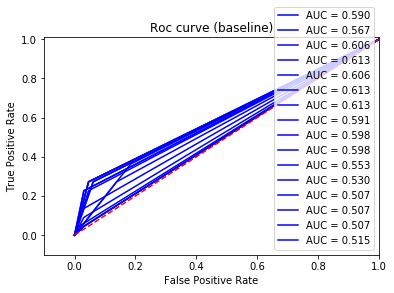

In [14]:
print(tpr_knn)
print(fpr_knn)

roc_aucs_knn_baseline = []
for i in range(0,len(tpr_knn)):
    #roc_aucs_knn_baseline.append(auc(fpr[i],tpr[i]))
    plt.plot(fpr_knn[i], tpr_knn[i], 'b',label='AUC = %0.3f'% auc(fpr_knn[i],tpr_knn[i]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc curve (baseline)")
plt.show()

[array([0.        , 0.45454545, 1.        ]), array([0.        , 0.27272727, 1.        ]), array([0.        , 0.31818182, 1.        ]), array([0.        , 0.13636364, 1.        ]), array([0.        , 0.09090909, 1.        ]), array([0.        , 0.04545455, 1.        ]), array([0.        , 0.04545455, 1.        ]), array([0.        , 0.04545455, 1.        ]), array([0., 0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.])]
[array([0.        , 0.13846154, 1.        ]), array([0.        , 0.10769231, 1.        ]), array([0.        , 0.07692308, 1.        ]), array([0.        , 0.06153846, 1.        ]), array([0.        , 0.06153846, 1.        ]), array([0.        , 0.03076923, 1.        ]), array([0.        , 0.01538462, 1.        ]), array([0.        , 0.01538462, 1.        ]), array([0.        , 0.01538462, 1.        ]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0

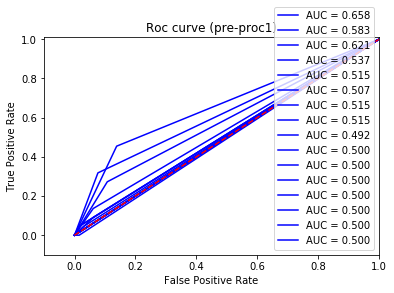

In [15]:
print(tpr_knn_pre1)
print(fpr_knn_pre1)

#roc_aucs_knn_baseline = []
for i in range(0,len(tpr_knn)):
    #roc_aucs_knn_baseline.append(auc(fpr[i],tpr[i]))
    plt.plot(fpr_knn_pre1[i], tpr_knn_pre1[i], 'b',label='AUC = %0.3f'% auc(fpr_knn_pre1[i],tpr_knn_pre1[i]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc curve (pre-proc1)")
plt.show()

[0.7011494252873564, 0.7126436781609196, 0.7701149425287356, 0.7816091954022989, 0.7701149425287356, 0.7816091954022989, 0.7816091954022989, 0.7701149425287356, 0.7816091954022989, 0.7816091954022989, 0.7586206896551724, 0.7471264367816092, 0.735632183908046, 0.735632183908046, 0.735632183908046, 0.7471264367816092]
[0.7586206896551724, 0.735632183908046, 0.7701149425287356, 0.735632183908046, 0.7241379310344828, 0.735632183908046, 0.7471264367816092, 0.7471264367816092, 0.735632183908046, 0.7471264367816092, 0.7471264367816092, 0.7471264367816092, 0.7471264367816092, 0.7471264367816092, 0.7471264367816092, 0.7471264367816092]
[0.823076923076923, 0.7769230769230769, 0.7615384615384615, 0.7384615384615385, 0.7461538461538462, 0.7615384615384615, 0.7230769230769231, 0.7384615384615385, 0.7076923076923077, 0.7153846153846154, 0.7076923076923077, 0.7076923076923077, 0.7, 0.6615384615384615, 0.6615384615384615, 0.6923076923076923]
[0.7586206896551724, 0.7816091954022989, 0.7816091954022989,

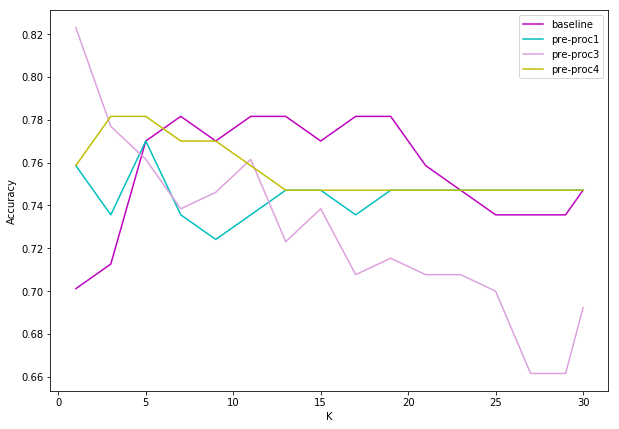

In [16]:
rcParams['figure.figsize'] = 10, 7

print(accurracies_knn)
print(accurracies_knn_pre1)
print(accurracies_knn_pre3)
print(accurracies_knn_pre4)

#accurracies_knn = [0.9888125, 0.989625, 0.9890625, 0.989125, 0.988625, 0.98875, 0.988375, 0.9881875, 0.987875, 0.9876875, 0.9876875, 0.9879375, 0.9880625, 0.987875, 0.9876875, 0.9876875]
#accurracies_knn_pre1 = [0.9380625, 0.9355625, 0.9415, 0.918125, 0.913375, 0.880875, 0.883375, 0.888, 0.883625, 0.8776875, 0.8728125, 0.866125, 0.8421875, 0.842125, 0.856, 0.8639375]


base_knn_acc = plt.plot(Ks, accurracies_knn,'m', label='baseline')
pre1_knn_acc = plt.plot(Ks, accurracies_knn_pre1,'c', label='pre-proc1')
pre2_knn_acc = plt.plot(Ks, accurracies_knn_pre3,'plum', label='pre-proc3')
pre2_knn_acc = plt.plot(Ks, accurracies_knn_pre4,'y', label='pre-proc4')
plt.ylabel("Accuracy")
plt.xlabel("K")
plt.legend()
plt.show()

[array([0.        , 0.45454545, 1.        ]), array([0.        , 0.36363636, 1.        ]), array([0.        , 0.18181818, 1.        ]), array([0.        , 0.13636364, 1.        ]), array([0.        , 0.13636364, 1.        ]), array([0.        , 0.04545455, 1.        ]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.])]
[array([0.        , 0.13846154, 1.        ]), array([0.        , 0.07692308, 1.        ]), array([0.        , 0.01538462, 1.        ]), array([0.        , 0.01538462, 1.        ]), array([0.        , 0.01538462, 1.        ]), array([0., 0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.])]


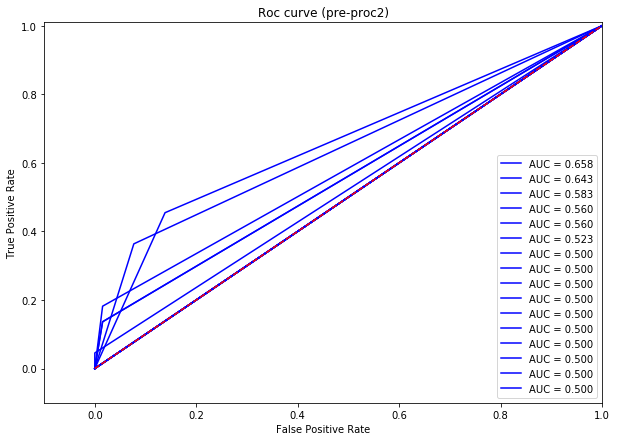

In [17]:
print(tpr_knn_pre4)
print(fpr_knn_pre4)

for i in range(0,len(fpr_knn_pre4)):
    plt.plot(fpr_knn_pre4[i], tpr_knn_pre4[i], 'b',label='AUC = %0.3f'% auc(fpr_knn_pre4[i],tpr_knn_pre4[i]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc curve (pre-proc2)")
plt.show()

[array([0.        , 0.89230769, 1.        ]), array([0.        , 0.89230769, 1.        ]), array([0.        , 0.86153846, 1.        ]), array([0.        , 0.89230769, 1.        ]), array([0.        , 0.86153846, 1.        ]), array([0.        , 0.89230769, 1.        ]), array([0.        , 0.84615385, 1.        ]), array([0.        , 0.86153846, 1.        ]), array([0.        , 0.78461538, 1.        ]), array([0.        , 0.78461538, 1.        ]), array([0.        , 0.81538462, 1.        ]), array([0.        , 0.78461538, 1.        ]), array([0.        , 0.73846154, 1.        ]), array([0.        , 0.69230769, 1.        ]), array([0.        , 0.67692308, 1.        ]), array([0.        , 0.64615385, 1.        ])]
[array([0.        , 0.24615385, 1.        ]), array([0.        , 0.33846154, 1.        ]), array([0.        , 0.33846154, 1.        ]), array([0.        , 0.41538462, 1.        ]), array([0.        , 0.36923077, 1.        ]), array([0.        , 0.36923077, 1.        ]), array([0

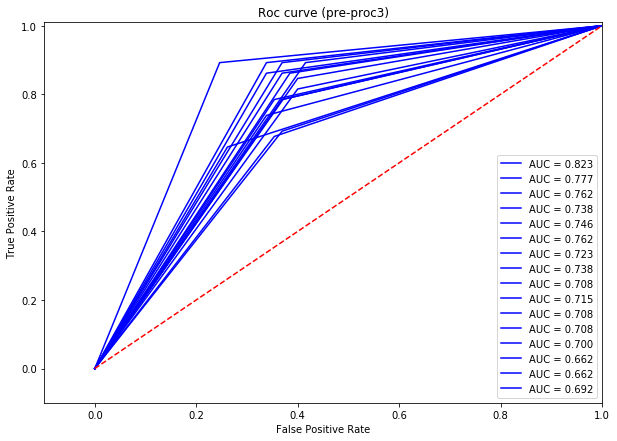

In [18]:
print(tpr_knn_pre3)
print(fpr_knn_pre3)

for i in range(0,len(fpr_knn_pre3)):
    plt.plot(fpr_knn_pre3[i], tpr_knn_pre3[i], 'b',label='AUC = %0.3f'% auc(fpr_knn_pre3[i],tpr_knn_pre3[i]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc curve (pre-proc3)")
plt.show()

# ------------------------------------------- Naive Bayes -------------------------------------

In [19]:
gnb = GaussianNB()

accurracy_NB_baseline, accurracy_NB_pre1, accurracy_NB_pre3, accurracy_NB_pre4 = [],[],[],[]
sensitivity_NB_baseline, sensitivity_NB_pre1, sensitivity_NB_pre3, sensitivity_NB_pre4 = [],[],[],[]
cost_NB_baseline, cost_NB_pre1, cost_NB_pre3, cost_NB_pre4 = [],[],[],[]

kf = model_selection.KFold(n_splits = 10)
print("--- BASELINE ---")
for train_index, test_index in kf.split(X,Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    model = gnb.fit(X_train,Y_train)
    predYNB = model.predict(X_test)
    cm = metrics.confusion_matrix(Y_test, predYNB,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test, Y_test)
    sensitivity = Sens[0]
    cost = cost[0]
    
    accurracy_NB_baseline.append(accurracy)
    sensitivity_NB_baseline.append(sensitivity)
    cost_NB_baseline.append(cost)
    
    print(cm)
    print("Sensitivity NB Baseline:", sensitivity)
    print("Specificity NB Baseline:", Spec[0])
    print("Cost NB Baseline:", cost)
    print("Acurracy NB Baseline:", accurracy)

print("--- PRE-1 ---")
for train_index, test_index in kf.split(X_preproc_1,Y):
    X_train, X_test = X_preproc_1.iloc[train_index], X_preproc_1.iloc[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    model = gnb.fit(X_train,Y_train)
    predYNB = model.predict(X_test)
    cm = metrics.confusion_matrix(Y_test, predYNB,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test, Y_test)
    sensitivity = Sens[0]
    cost = cost[0]
    
    accurracy_NB_pre1.append(accurracy)
    sensitivity_NB_pre1.append(sensitivity)
    cost_NB_pre1.append(cost)
    
    print(cm)
    print("Sensitivity NB Baseline:", sensitivity)
    print("Specificity NB Baseline:", Spec[0])
    print("Cost NB Baseline:", cost)
    print("Acurracy NB Baseline:", accurracy)
    
print("--- PRE-3 ---")
for train_index, test_index in kf.split(X_preproc_3,Y_preproc_3):
    X_train, X_test = X_preproc_3.iloc[train_index], X_preproc_3.iloc[test_index]
    Y_train, Y_test = Y_preproc_3[train_index], Y_preproc_3[test_index]
    
    model = gnb.fit(X_train,Y_train)
    predYNB = model.predict(X_test)
    cm = metrics.confusion_matrix(Y_test, predYNB,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test, Y_test)
    sensitivity = Sens[0]
    cost = cost[0]
    
    accurracy_NB_pre3.append(accurracy)
    sensitivity_NB_pre3.append(sensitivity)
    cost_NB_pre3.append(cost)
    
    print(cm)
    print("Sensitivity NB Baseline:", sensitivity)
    print("Specificity NB Baseline:", Spec[0])
    print("Cost NB Baseline:", cost)
    print("Acurracy NB Baseline:", accurracy)
    
print("--- PRE-4 ---")
for train_index, test_index in kf.split(X_preproc_4,Y):
    X_train, X_test = X_preproc_4.iloc[train_index], X_preproc_4.iloc[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    model = gnb.fit(X_train,Y_train)
    predYNB = model.predict(X_test)
    cm = metrics.confusion_matrix(Y_test, predYNB,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test, Y_test)
    sensitivity = Sens[0]
    cost = cost[0]
    
    accurracy_NB_pre4.append(accurracy)
    sensitivity_NB_pre4.append(sensitivity)
    cost_NB_pre4.append(cost)
    
    print(cm)
    print("Sensitivity NB Baseline:", sensitivity)
    print("Specificity NB Baseline:", Spec[0])
    print("Cost NB Baseline:", cost)
    print("Acurracy NB Baseline:", accurracy)

print("------------------------------------------------------------------------------------------")
    
print("Sensitivity NB Baseline:", np.mean(sensitivity_NB_baseline))
print("Cost NB Baseline:", np.mean(cost_NB_baseline))
print("Acurracy NB Baseline:", np.mean(accurracy_NB_baseline))
print('\n')
print("Sensitivity NB Pre1:", np.mean(sensitivity_NB_pre1))
print("Cost NB Pre1:", np.mean(cost_NB_pre1))
print("Acurracy NB Pre1:", np.mean(accurracy_NB_pre1))
print('\n')
print("Sensitivity NB Pre3:", np.mean(sensitivity_NB_pre3))
print("Cost NB Pre3:", np.mean(cost_NB_pre3))
print("Acurracy NB Pre3:", np.mean(accurracy_NB_pre3))
print('\n')
print("Sensitivity NB Pre4:", np.mean(sensitivity_NB_pre4))
print("Cost NB Pre4:", np.mean(cost_NB_pre4))
print("Acurracy NB Pre4:", np.mean(accurracy_NB_pre4))

mean_accuracy_NB_baseline = np.mean(accurracy_NB_baseline)
mean_accuracy_NB_pre1 = np.mean(accurracy_NB_pre1)
mean_accuracy_NB_pre3 = np.mean(accurracy_NB_pre3)
mean_accuracy_NB_pre4 = np.mean(accurracy_NB_pre4)

mean_cost_NB_baseline = np.mean(cost_NB_baseline)
mean_cost_NB_pre1 = np.mean(cost_NB_pre1)
mean_cost_NB_pre3 = np.mean(cost_NB_pre3)
mean_cost_NB_pre4 = np.mean(cost_NB_pre4)

mean_sensitivity_NB_baseline = np.mean(sensitivity_NB_baseline)
mean_sensitivity_NB_pre1 = np.mean(sensitivity_NB_pre1)
mean_sensitivity_NB_pre3 = np.mean(sensitivity_NB_pre3)
mean_sensitivity_NB_pre4 = np.mean(sensitivity_NB_pre4)

--- BASELINE ---
[[10  1]
 [ 3 15]]
Sensitivity NB Baseline: 0.9090909090909091
Specificity NB Baseline: 0.8333333333333334
Cost NB Baseline: 530
Acurracy NB Baseline: 0.8620689655172413
[[ 6  2]
 [ 8 13]]
Sensitivity NB Baseline: 0.75
Specificity NB Baseline: 0.6190476190476191
Cost NB Baseline: 1080
Acurracy NB Baseline: 0.6551724137931034
[[ 3  7]
 [ 3 16]]
Sensitivity NB Baseline: 0.3
Specificity NB Baseline: 0.8421052631578947
Cost NB Baseline: 3530
Acurracy NB Baseline: 0.6551724137931034
[[ 1  3]
 [ 4 21]]
Sensitivity NB Baseline: 0.25
Specificity NB Baseline: 0.84
Cost NB Baseline: 1540
Acurracy NB Baseline: 0.7586206896551724
[[ 2  5]
 [ 1 21]]
Sensitivity NB Baseline: 0.2857142857142857
Specificity NB Baseline: 0.9545454545454546
Cost NB Baseline: 2510
Acurracy NB Baseline: 0.7931034482758621
[[ 0  4]
 [ 4 21]]
Sensitivity NB Baseline: 0.0
Specificity NB Baseline: 0.84
Cost NB Baseline: 2040
Acurracy NB Baseline: 0.7241379310344828
[[ 2  2]
 [ 0 25]]
Sensitivity NB Baseline: 

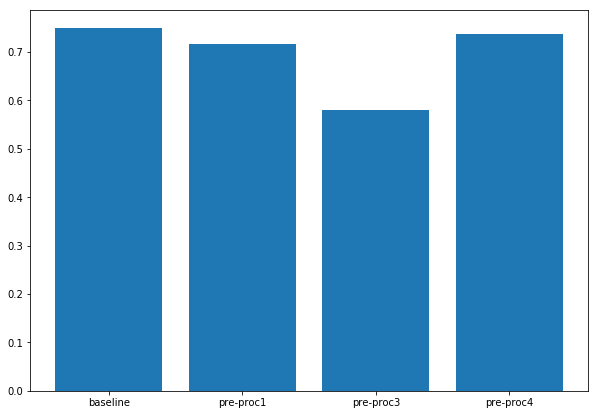

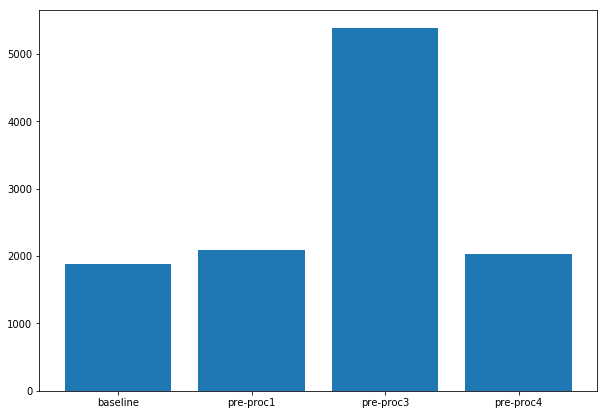

In [20]:
plt.figure()
plt.bar(["baseline","pre-proc1","pre-proc3","pre-proc4"],[mean_accuracy_NB_baseline,mean_accuracy_NB_pre1,mean_accuracy_NB_pre3,mean_accuracy_NB_pre4])
plt.show()

plt.figure()
plt.bar(["baseline","pre-proc1","pre-proc3","pre-proc4"],[mean_cost_NB_baseline,mean_cost_NB_pre1,mean_cost_NB_pre3,mean_cost_NB_pre4])
plt.show()

# C4.5 (decision tree)


varying max_depth

In [24]:
depths = range(1,21)

accurracies_DT_depth = []
costs_DT_depth = []
sensitivities_DT_depth = []

accurracies_DT_depth_pre4= []
costs_DT_depth_pre4 = []
sensitivities_DT_depth_pre4= []

X_train0, X_test0, Y_train0, Y_test0 = model_selection.train_test_split(X,Y, train_size = 0.7, test_size = 0.3, stratify = Y)
X_train4, X_test4, Y_train4, Y_test4 = model_selection.train_test_split(X_preproc_4,Y, train_size = 0.7, test_size = 0.3, stratify = Y)
for depth in depths:
    
    
    print("max_depth =", depth)
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    
    model = clf.fit(X_train0, Y_train0)
    predYClf = model.predict(X_test0)
    cmClf = metrics.confusion_matrix(Y_test0, predYClf,labels=[1, 0])
    accuracy = model.score(X_test0, Y_test0)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_depth.append(accuracy)
    costs_DT_depth.append(cost[0])
    sensitivities_DT_depth.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
     
    print("---4---")
    model = clf.fit(X_train4, Y_train4)
    predYClf = model.predict(X_test4)
    cmClf = metrics.confusion_matrix(Y_test4, predYClf,labels=[1, 0])
    accuracy = model.score(X_test4, Y_test4)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_depth_pre4.append(accuracy)
    costs_DT_depth_pre4.append(cost[0])
    sensitivities_DT_depth_pre4.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("--------------------------------------------------------------")
    
print("Accuracies baseline: ", accurracies_DT_depth)
print("Costs baseline: ", costs_DT_depth)
print("Sensitivities baseline: ", sensitivities_DT_depth)

print("Accuracies pre4: ", accurracies_DT_depth_pre4)
print("Costs pre4: ", costs_DT_depth_pre4)
print("Sensitivities pre4: ", sensitivities_DT_depth_pre4)

max_depth = 1
[[ 3 19]
 [ 5 60]]
Accurracy: 0.7241379310344828
Sensitivity: 0.13636363636363635
Specificity: 0.9230769230769231
Cost: [9550 2690]
---4---
[[ 2 20]
 [ 1 64]]
Accurracy: 0.7586206896551724
Sensitivity: 0.09090909090909091
Specificity: 0.9846153846153847
Cost: [10010   700]
--------------------------------------------------------------
max_depth = 2
[[ 7 15]
 [ 6 59]]
Accurracy: 0.7586206896551724
Sensitivity: 0.3181818181818182
Specificity: 0.9076923076923077
Cost: [7560 3150]
---4---
[[ 8 14]
 [ 3 62]]
Accurracy: 0.8045977011494253
Sensitivity: 0.36363636363636365
Specificity: 0.9538461538461539
Cost: [7030 1640]
--------------------------------------------------------------
max_depth = 3
[[ 7 15]
 [ 5 60]]
Accurracy: 0.7701149425287356
Sensitivity: 0.3181818181818182
Specificity: 0.9230769230769231
Cost: [7550 2650]
---4---
[[ 6 16]
 [ 4 61]]
Accurracy: 0.7701149425287356
Sensitivity: 0.2727272727272727
Specificity: 0.9384615384615385
Cost: [8040 2160]
-----------------

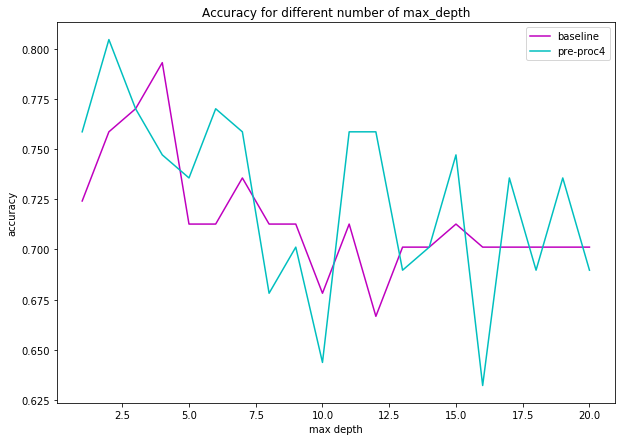

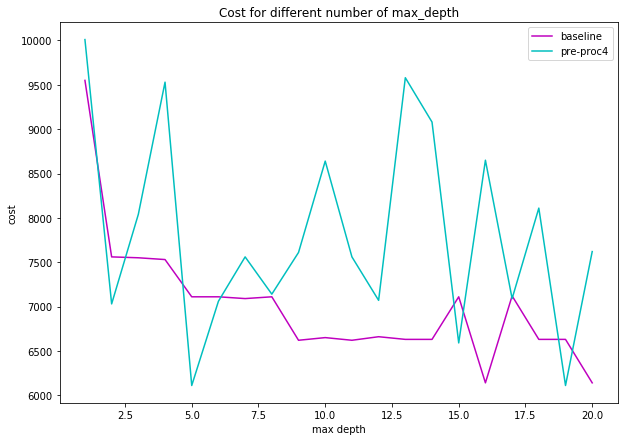

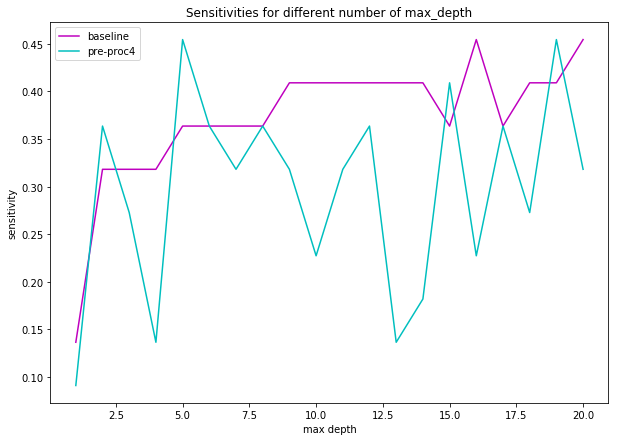

In [25]:
Ks = range(1, 21)

plt.figure()
plt.title('Accuracy for different number of max_depth')
plt.plot(Ks, accurracies_DT_depth,'m', label='baseline')
plt.plot(Ks, accurracies_DT_depth_pre4,'c', label='pre-proc4')
plt.legend()
plt.xlabel("max depth")
plt.ylabel("accuracy")
plt.show()

plt.figure()
plt.title('Cost for different number of max_depth')
plt.plot(Ks, costs_DT_depth,'m', label='baseline')
plt.plot(Ks, costs_DT_depth_pre4,'c', label='pre-proc4')
plt.legend()
plt.xlabel("max depth")
plt.ylabel("cost")
plt.show()

plt.figure()
plt.title('Sensitivities for different number of max_depth')
plt.plot(Ks, sensitivities_DT_depth,'m', label='baseline')
plt.plot(Ks, sensitivities_DT_depth_pre4,'c', label='pre-proc4')
plt.xlabel("max depth")
plt.ylabel("sensitivity")
plt.legend()
plt.show()

In [23]:
splits = range(2,21,2)

accurracies_DT_poda0 = []
costs_DT_poda0 = []
sensitivities_DT_poda0 = []

accurracies_DT_poda4 = []
costs_DT_poda4 = []
sensitivities_DT_poda4 = []

accurracies_DT_0 = []
costs_DT_0 = []
sensitivities_DT_0 = []

accurracies_DT_4 = []
costs_DT_4 = []
sensitivities_DT_4 = []

X_train0, X_test0, Y_train0, Y_test0 = model_selection.train_test_split(X,Y, train_size = 0.7, test_size = 0.3, stratify = Y)    
X_train4, X_test4, Y_train4, Y_test4 = model_selection.train_test_split(X_preproc_4,Y, train_size = 0.7, test_size = 0.3, stratify = Y)
for split in splits:
    print(split)
    
    print("---0 s/poda---")
    clf = tree.DecisionTreeClassifier(min_samples_split=split)
    model = clf.fit(X_train0, Y_train0)
    predYClf = model.predict(X_test0)
    cmClf = metrics.confusion_matrix(Y_test0, predYClf,labels=[1, 0])
    accuracy = model.score(X_test0, Y_test0)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_0.append(accuracy)
    costs_DT_0.append(cost[0])
    sensitivities_DT_0.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---0 c/poda---")
    clf = tree.DecisionTreeClassifier(max_depth=8,min_samples_split=split)
    model = clf.fit(X_train0, Y_train0)
    predYClf = model.predict(X_test0)
    cmClf = metrics.confusion_matrix(Y_test0, predYClf,labels=[1, 0])
    accuracy = model.score(X_test0, Y_test0)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_poda0.append(accuracy)
    costs_DT_poda0.append(cost[0])
    sensitivities_DT_poda0.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---4 s/poda---")
    clf = tree.DecisionTreeClassifier(min_samples_split=split)
    model = clf.fit(X_train4, Y_train4)
    predYClf = model.predict(X_test4)
    cmClf = metrics.confusion_matrix(Y_test4, predYClf,labels=[1, 0])
    accuracy = model.score(X_test4, Y_test4)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_4.append(accuracy)
    costs_DT_4.append(cost[0])
    sensitivities_DT_4.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---4 c/poda---")
    
    clf = tree.DecisionTreeClassifier(max_depth=8,min_samples_split=split)
    model = clf.fit(X_train4, Y_train4)
    predYClf = model.predict(X_test4)
    cmClf = metrics.confusion_matrix(Y_test4, predYClf,labels=[1, 0])
    accuracy = model.score(X_test4, Y_test4)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_poda4.append(accuracy)
    costs_DT_poda4.append(cost[0])
    sensitivities_DT_poda4.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("--------------------------------------------------------------")
print("Accuracies 0: ", accurracies_DT_0)
print("Costs 0: ", costs_DT_0)
print("Sensitivities 0: ", sensitivities_DT_0)

print("Accuracies 4: ", accurracies_DT_4)
print("Costs 4: ", costs_DT_4)
print("Sensitivities 4: ", sensitivities_DT_4)

print("Accuracies poda0: ", accurracies_DT_poda0)
print("Costs poda0: ", costs_DT_poda0)
print("Sensitivities poda0: ", sensitivities_DT_poda0)

print("Accuracies poda4: ", accurracies_DT_poda4)
print("Costs poda4: ", costs_DT_poda4)
print("Sensitivities poda4: ", sensitivities_DT_poda4)

2
---0 s/poda---
[[10 12]
 [11 54]]
Accurracy: 0.735632183908046
Sensitivity: 0.45454545454545453
Specificity: 0.8307692307692308
Cost: [6110 5620]
---0 c/poda---
[[10 12]
 [ 9 56]]
Accurracy: 0.7586206896551724
Sensitivity: 0.45454545454545453
Specificity: 0.8615384615384616
Cost: [6090 4620]
---4 s/poda---
[[11 11]
 [16 49]]
Accurracy: 0.6896551724137931
Sensitivity: 0.5
Specificity: 0.7538461538461538
Cost: [5660 8110]
---4 c/poda---
[[ 8 14]
 [ 7 58]]
Accurracy: 0.7586206896551724
Sensitivity: 0.36363636363636365
Specificity: 0.8923076923076924
Cost: [7070 3640]
--------------------------------------------------------------
4
---0 s/poda---
[[10 12]
 [11 54]]
Accurracy: 0.735632183908046
Sensitivity: 0.45454545454545453
Specificity: 0.8307692307692308
Cost: [6110 5620]
---0 c/poda---
[[10 12]
 [ 9 56]]
Accurracy: 0.7586206896551724
Sensitivity: 0.45454545454545453
Specificity: 0.8615384615384616
Cost: [6090 4620]
---4 s/poda---
[[ 9 13]
 [11 54]]
Accurracy: 0.7241379310344828
Sensi

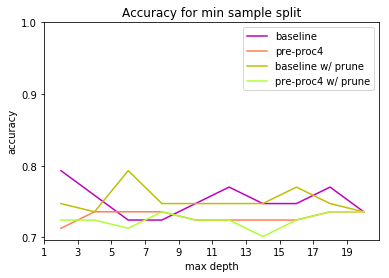

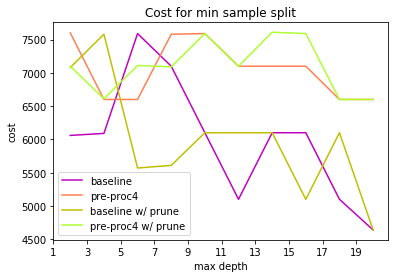

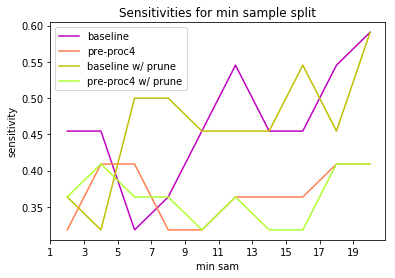

In [44]:
Ks = range(2,21,2)

plt.figure()
plt.title('Accuracy for min sample split')
plt.plot(Ks, accurracies_DT_0,'m', label='baseline')
plt.plot(Ks, accurracies_DT_4,'coral', label='pre-proc4')
plt.plot(Ks, accurracies_DT_poda0,'y', label='baseline w/ prune')
plt.plot(Ks, accurracies_DT_poda4,'greenyellow', label='pre-proc4 w/ prune')
plt.legend()
plt.xlabel("max depth")
plt.ylabel("accuracy")
plt.xticks(np.arange(1, 21, step=2))
plt.yticks(np.arange(0.7, 1, step=0.1))
plt.show()

plt.figure()
plt.title('Cost for min sample split')
plt.plot(Ks, costs_DT_0,'m', label='baseline')
plt.plot(Ks, costs_DT_4,'coral', label='pre-proc4')
plt.plot(Ks, costs_DT_poda0,'y', label='baseline w/ prune')
plt.plot(Ks, costs_DT_poda4,'greenyellow', label='pre-proc4 w/ prune')
plt.legend()
plt.xlabel("max depth")
plt.ylabel("cost")
plt.xticks(np.arange(1, 21, step=2))
plt.show()

plt.figure()
plt.title('Sensitivities for min sample split')
plt.plot(Ks, sensitivities_DT_0,'m', label='baseline')
plt.plot(Ks, sensitivities_DT_4,'coral', label='pre-proc4')
plt.plot(Ks, sensitivities_DT_poda0,'y', label='baseline w/ prune')
plt.plot(Ks, sensitivities_DT_poda4,'greenyellow', label='pre-proc4 w/ prune')
plt.xlabel("min sam")
plt.ylabel("sensitivity")
plt.xticks(np.arange(1, 21, step=2))
plt.legend()
plt.show()

# Random Forest

In [79]:
ntrees = range(1,21,2)

accurracies_RF_ntree_0 = []
costs_RF_ntree_0 = []
sensitivities_RF_ntree_0 = []

accurracies_RF_ntree_0poda = []
costs_RF_ntree_0poda = []
sensitivities_RF_ntree_0poda = []

accurracies_RF_ntree_4 = []
costs_RF_ntree_4 = []
sensitivities_RF_ntree_4 = []

accurracies_RF_ntree_4poda = []
costs_RF_ntree_4poda = []
sensitivities_RF_ntree_4poda = []

X_train0, X_test0, Y_train0, Y_test0 = model_selection.train_test_split(X,Y, train_size = 0.7, test_size = 0.3, stratify = Y)
X_train4, X_test4, Y_train4, Y_test4 = model_selection.train_test_split(X_preproc_4,Y, train_size = 0.7, test_size = 0.3, stratify = Y)
for n in ntrees:
    
    print("n trees =", n)
    
    print("--- 0 s/poda ---")
    
    rf = RandomForestClassifier(n_estimators =n)
    model = rf.fit(X_train0, Y_train0)
    predYClf = model.predict(X_test0)
     
    cmClf = metrics.confusion_matrix(Y_test0, predYClf,labels=[1, 0])
    accuracy = model.score(X_test0, Y_test0)
    Sens, Spec, cost = compute_metrics(cmClf)

    accurracies_RF_ntree_0.append(accuracy)
    costs_RF_ntree_0.append(cost[0])
    sensitivities_RF_ntree_0.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---0 c/poda ---")
    
    rf = RandomForestClassifier(n_estimators =n, max_depth=10)
    model = rf.fit(X_train0, Y_train0)
    predYClf = model.predict(X_test0)
     
    cmClf = metrics.confusion_matrix(Y_test0, predYClf,labels=[1, 0])
    accuracy = model.score(X_test0, Y_test0)
    Sens, Spec, cost = compute_metrics(cmClf)

    accurracies_RF_ntree_0poda.append(accuracy)
    costs_RF_ntree_0poda.append(cost[0])
    sensitivities_RF_ntree_0poda.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---4 s/poda---")
    
    rf = RandomForestClassifier(n_estimators =n, max_depth=10)
    model = rf.fit(X_train4, Y_train4)
    predYClf = model.predict(X_test4)
    cmClf = metrics.confusion_matrix(Y_test4, predYClf,labels=[1, 0])
    accuracy = model.score(X_test4, Y_test4)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_RF_ntree_4.append(accuracy)
    costs_RF_ntree_4.append(cost[0])
    sensitivities_RF_ntree_4.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---4 c/poda---")
    
    rf = RandomForestClassifier(n_estimators =n, max_depth=10)
    model = rf.fit(X_train4, Y_train4)
    predYClf = model.predict(X_test4)
    cmClf = metrics.confusion_matrix(Y_test4, predYClf,labels=[1, 0])
    accuracy = model.score(X_test4, Y_test4)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_RF_ntree_4poda.append(accuracy)
    costs_RF_ntree_4poda.append(cost[0])
    sensitivities_RF_ntree_4poda.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("--------------------------------------------------------------")

print("Accuracies 0: ", accurracies_RF_ntree_0)
print("Costs 0: ", costs_RF_ntree_0)
print("Sensitivities 0: ", sensitivities_RF_ntree_0)

print("Accuracies 0 poda: ", accurracies_RF_ntree_0poda)
print("Costs 0 poda: ", costs_RF_ntree_0poda)
print("Sensitivities 0 poda: ", sensitivities_RF_ntree_0poda)

print("Accuracies 4: ", accurracies_RF_ntree_4)
print("Costs 4: ", costs_RF_ntree_4)
print("Sensitivities 4: ", sensitivities_RF_ntree_4)

print("Accuracies 4 poda: ", accurracies_RF_ntree_4poda)
print("Costs 4 poda: ", costs_RF_ntree_4poda)
print("Sensitivities 4 poda: ", sensitivities_RF_ntree_4poda)

n trees = 1
--- 0 s/poda ---
[[14  8]
 [ 8 57]]
Accurracy: 0.8160919540229885
Sensitivity: 0.6363636363636364
Specificity: 0.8769230769230769
Cost: [4080 4080]
---0 c/poda ---
[[13  9]
 [12 53]]
Accurracy: 0.7586206896551724
Sensitivity: 0.5909090909090909
Specificity: 0.8153846153846154
Cost: [4620 6090]
---4 s/poda---
[[ 9 13]
 [12 53]]
Accurracy: 0.7126436781609196
Sensitivity: 0.4090909090909091
Specificity: 0.8153846153846154
Cost: [6620 6130]
---4 c/poda---
[[ 5 17]
 [ 8 57]]
Accurracy: 0.7126436781609196
Sensitivity: 0.22727272727272727
Specificity: 0.8769230769230769
Cost: [8580 4170]
--------------------------------------------------------------
n trees = 3
--- 0 s/poda ---
[[ 9 13]
 [ 9 56]]
Accurracy: 0.7471264367816092
Sensitivity: 0.4090909090909091
Specificity: 0.8615384615384616
Cost: [6590 4630]
---0 c/poda ---
[[ 9 13]
 [14 51]]
Accurracy: 0.6896551724137931
Sensitivity: 0.4090909090909091
Specificity: 0.7846153846153846
Cost: [6640 7130]
---4 s/poda---
[[ 7 15]
 [13 5

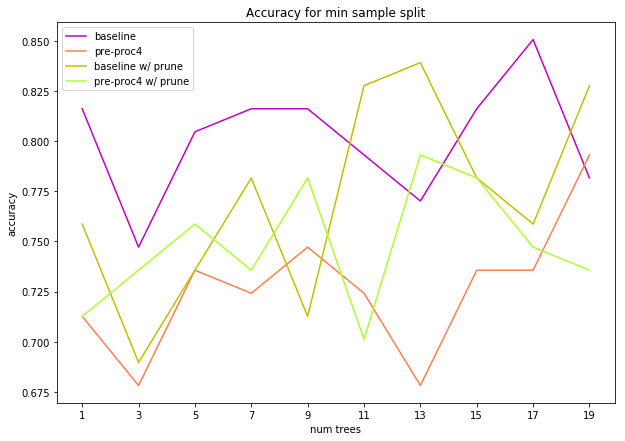

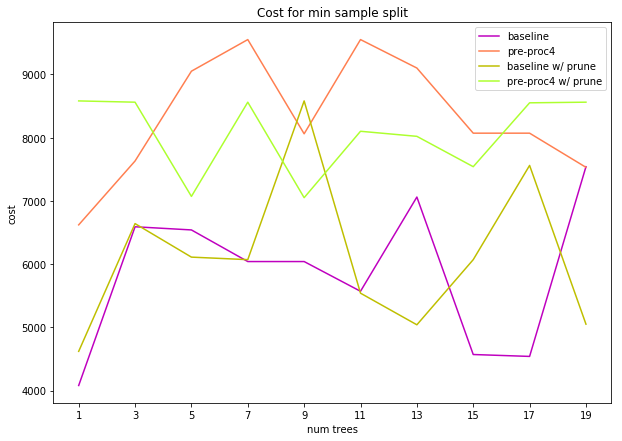

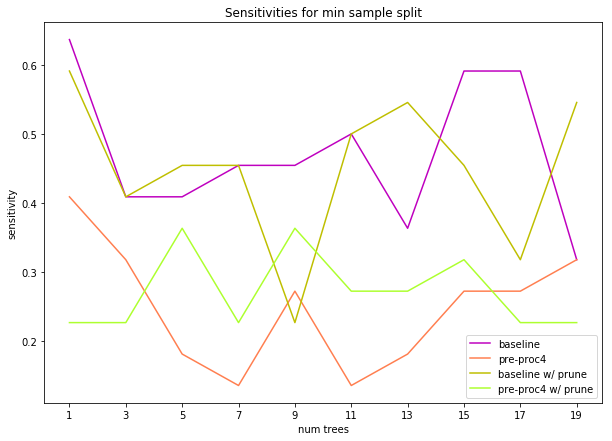

In [80]:
Ks = range(1,21,2)

plt.figure()
plt.title('Accuracy for min sample split')
plt.plot(Ks, accurracies_RF_ntree_0,'m', label='baseline')
plt.plot(Ks, accurracies_RF_ntree_4,'coral', label='pre-proc4')
plt.plot(Ks, accurracies_RF_ntree_0poda,'y', label='baseline w/ prune')
plt.plot(Ks, accurracies_RF_ntree_4poda,'greenyellow', label='pre-proc4 w/ prune')
plt.legend()
plt.xlabel("num trees")
plt.ylabel("accuracy")
plt.xticks(np.arange(1, 21, step=2))
plt.show()

plt.figure()
plt.title('Cost for min sample split')
plt.plot(Ks, costs_RF_ntree_0,'m', label='baseline')
plt.plot(Ks, costs_RF_ntree_4,'coral', label='pre-proc4')
plt.plot(Ks, costs_RF_ntree_0poda,'y', label='baseline w/ prune')
plt.plot(Ks, costs_RF_ntree_4poda,'greenyellow', label='pre-proc4 w/ prune')
plt.legend()
plt.xlabel("num trees")
plt.ylabel("cost")
plt.xticks(np.arange(1, 21, step=2))
plt.show()

plt.figure()
plt.title('Sensitivities for min sample split')
plt.plot(Ks, sensitivities_RF_ntree_0,'m', label='baseline')
plt.plot(Ks, sensitivities_RF_ntree_4,'coral', label='pre-proc4')
plt.plot(Ks, sensitivities_RF_ntree_0poda,'y', label='baseline w/ prune')
plt.plot(Ks, sensitivities_RF_ntree_4poda,'greenyellow', label='pre-proc4 w/ prune')
plt.xlabel("num trees")
plt.ylabel("sensitivity")
plt.xticks(np.arange(1, 21, step=2))
plt.legend()
plt.show()

# K-fold Baseline

In [83]:
kf = model_selection.KFold(n_splits = 10)
kfold_baseline_accurracy_knn, kfold_baseline_costs_knn = [], []
kfold_baseline_accurracy_dtp, kfold_baseline_costs_dtp, kfold_baseline_accurracy_dt, kfold_baseline_costs_dt = [], [], [], []
kfold_baseline_accurracy_rfp, kfold_baseline_costs_rfp, kfold_baseline_accurracy_rf, kfold_baseline_costs_rf = [], [], [], []

ks = range(1,31)

for train_index, test_index in kf.split(X,Y):
    #------------------------------KNN--------------------------
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
    model = knn.fit(X_train,Y_train)
    predY = model.predict(X_test)

    cm = metrics.confusion_matrix(Y_test, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test, Y_test)
    kfold_baseline_accurracy_knn.append(accurracy)
    kfold_baseline_costs_knn.append(cost[0])
    #------------------------------DT--------------------------
    
    #print("---0 s/poda---")
    clf = tree.DecisionTreeClassifier(min_samples_split=5)
    model = clf.fit(X_train, Y_train)
    predYClf = model.predict(X_test)
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    kfold_baseline_accurracy_dt.append(accuracy)
    kfold_baseline_costs_dt.append(cost[0])
    
    #print("---0 c/poda---")
    clf = tree.DecisionTreeClassifier(max_depth=8,min_samples_split=5)
    model = clf.fit(X_train, Y_train)
    predYClf = model.predict(X_test)
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    kfold_baseline_accurracy_dtp.append(accuracy)
    kfold_baseline_costs_dtp.append(cost[0])
    
    #------------------------------RF--------------------------
    
    #print("--- 0 s/poda ---")
    
    rf = RandomForestClassifier(n_estimators =n)
    model = rf.fit(X_train, Y_train)
    predYClf = model.predict(X_test)
     
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)

    kfold_baseline_accurracy_rf.append(accuracy)
    kfold_baseline_costs_rf.append(cost[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    #print("---0 c/poda ---")
    
    rf = RandomForestClassifier(n_estimators =n, max_depth=10)
    model = rf.fit(X_train, Y_train)
    predYClf = model.predict(X_test)
     
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)

    kfold_baseline_accurracy_rfp.append(accuracy)
    kfold_baseline_costs_rfp.append(cost[0])

[[ 5  6]
 [ 2 16]]
Accurracy: 0.7241379310344828
Sensitivity: 0.45454545454545453
Specificity: 0.8888888888888888
Cost: [3020 1060]
[[ 5  3]
 [ 1 20]]
Accurracy: 0.8620689655172413
Sensitivity: 0.625
Specificity: 0.9523809523809523
Cost: [1510  530]
[[ 3  7]
 [ 0 19]]
Accurracy: 0.7586206896551724
Sensitivity: 0.3
Specificity: 1.0
Cost: [3500   70]
[[ 1  3]
 [ 3 22]]
Accurracy: 0.7931034482758621
Sensitivity: 0.25
Specificity: 0.88
Cost: [1530 1530]
[[ 1  6]
 [ 0 22]]
Accurracy: 0.7931034482758621
Sensitivity: 0.14285714285714285
Specificity: 1.0
Cost: [3000   60]
[[ 1  3]
 [ 1 24]]
Accurracy: 0.8620689655172413
Sensitivity: 0.25
Specificity: 0.96
Cost: [1510  530]
[[ 2  2]
 [ 1 24]]
Accurracy: 0.896551724137931
Sensitivity: 0.5
Specificity: 0.96
Cost: [1010  520]
[[ 4  4]
 [ 2 18]]
Accurracy: 0.7857142857142857
Sensitivity: 0.5
Specificity: 0.9
Cost: [2020 1040]
[[ 2  4]
 [ 2 20]]
Accurracy: 0.7857142857142857
Sensitivity: 0.3333333333333333
Specificity: 0.9090909090909091
Cost: [2020

NameError: name 'Ks' is not defined

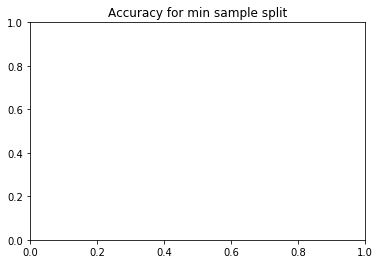

In [2]:
plt.figure()
plt.title('Accuracy for min sample split')
plt.plot(Ks, kfold_baseline_accurracy_knn,'m', label='knn')
plt.plot(Ks, kfold_baseline_accurracy_dt,'coral', label='DT')
plt.plot(Ks, kfold_baseline_accurracy_dtp,'y', label='DT w/ prune')
plt.plot(Ks, kfold_baseline_accurracy_rf,'greenyellow', label='RF')
plt.plot(Ks, kfold_baseline_accurracy_rfp,'b', label='RF w/ prune')
plt.plot(Ks, mean_accuracy_NB_baseline,'red','--', label='RF w/ prune')
plt.legend()
plt.xlabel("K")
plt.ylabel("Cost")
plt.title("K-fold Baseline")
plt.xticks(np.arange(1, 21, step=2))
plt.show()

plt.figure()
plt.title('Accuracy for min sample split')
plt.plot(Ks, kfold_baseline_cost_knn,'m', label='knn')
plt.plot(Ks, kfold_baseline_cost_dt,'coral', label='DT')
plt.plot(Ks, kfold_baseline_cost_dtp,'y', label='DT w/ prune')
plt.plot(Ks, kfold_baseline_cost_rf,'greenyellow', label='RF')
plt.plot(Ks, kfold_baseline_cost_rfp,'b', label='RF w/ prune')
plt.plot(Ks, mean_accuracy_NB_baseline,'red','--', label='RF w/ prune')
plt.legend()
plt.xlabel("K")
plt.ylabel("Cost")
plt.title("K-fold Baseline")
plt.xticks(np.arange(1, 21, step=2))
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cmClf , classes=labels, title='Confusion matrix')
plt.show()